In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as md
import os
import glob
import pyart
import pytda
import awot
import pyradarmet
from netCDF4 import date2num, num2date
from awot.graph import create_basemap, FlightLevel, RadarHorizontalPlot
%matplotlib inline

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning, module='.*/IPython/.*')

/Users/guy/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:66: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  inline backend."""
/Users/guy/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:71: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  'retina', 'jpeg', 'svg', 'pdf'.""")
/Users/guy/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:85: DeprecationWarning: metadata {'config': True} was set from the constructor.  Metadata should be set using the .tag() method, e.g., Int().tag(key1='value1', key2='value2')
  use `figure_formats` instead)""")
/Users/guy/anaconda/lib/python2.7/site-packages/ipykernel/pylab/config.py:95: DeprecationWarning: metadata {'config': True} was set from the constructor.  Met

In [2]:
filename = '/Users/guy/data/pecan/nex2/kuex/KUEX20150611_031925_turb.nc'
#KUEX20150611_031925_V06.gz'
rKUEX = pyart.io.read(filename)

fCHILL = '/Users/guy/data/t28/tcad1999/CHILL/chill_cfrad_turb_19990611_210817.nc'
rfiles = sorted(glob.glob(os.path.join('/Users/guy/data/t28/tcad1999/', 'CHILL')+'/chill*.nc'))
rCHILL = pyart.io.read(fCHILL)

In [3]:
def join_radars(r1, r2):
    rj = pyart.util.radar_utils.join_radar(r1, r2)
    return rj

rflist = []
for filen, filer in enumerate(rfiles):
    rflist.append(pyart.io.read(filer))

rCHILLj = join_radars(rflist[0], rflist[1])
for rad in rflist[2:]:
    rCHILLj.time['data'] = date2num(rCHILLj.time['data'], rCHILLj.time['units'])
    rCHILLj = join_radars(rCHILLj, rad)
#    print(rCHILLj.time['data'].shape,rCHILLj.fields[rCHILL.fields.keys()[0]]['data'].shape)

In [4]:
name_map = {
#        'time': 'time',
            # Aircraft Position
            'longitude': 'LONC',
            'latitude': 'LATC',
            'altitude': 'ztrue',
            'pressure_altitude': 'PALT',
            'tas': 'tas',
            'ias': 'aias',
            'true_heading': 'AVthead',
            'pitch': 'AVpitch',
            'roll_angle': 'AVroll',
            # Atmospheric State
            'pressure': 'pmb',
            'temperature': 'trf',
            'dewpoint_temperature': 'tdplicor',
            'thetad': 'thetad',
            'thetae': 'thetae',
            'relative_humidity': 'rh',
            'mixing_ratio': 'mr',
            'lwc': 'lwc100',
            'turb': 'turb',
            'g_accel': 'avnorma',
            # Radiometric
            'irtop': 'irtc',
            'irbottom': 'irbc',
            'swtop': 'swt',
            'swbottom': 'swb',
            # Wind derivations
            'Uwind': 'avuwind',
            'Vwind': 'avvwind',
            'Wwind': 'avwwind',
            'longitudinal_wind': 'avux',
            'latitudinal_wind': 'avvy',
            'wind_dir': 'avwdir',
            'wind_spd': 'axwmag',
            # Licor Concentrations
            'co2_conc': 'co21s',
            'h2o_conc': 'h2o1s',
            # Aerosol
            'pcasp_num': 'AS200_OBR',
            'pcasp_conc': 'CS200_OBR',
            'pcasp_mean_diam': 'DBARP_OBR',
            'pcasp_surf_area_conc': 'PSFCP_OBR',
            'pcasp_vol_conc': 'PVOLP_OBR',
            # Cloud Physics
            'conc_cpc': 'cpc_conc',
            # Miscellaneous
            'topo': 'topo'}

#flight = awot.io.read_netcdf(os.path.join('/Users/guy/data/pecan', '20150611.c50.nc'), mapping_dict=name_map)
fltKA = awot.io.read_netcdf(os.path.join('/Users/guy/data/pecan', '20150611.c1.nc'), mapping_dict=name_map)
flt28 = awot.io.read_netcdf(os.path.join('/Users/guy/data/t28/tcad1999','flight', 'T28_TCAD1999_728.nc'), time_var='Time', platform='T-28')

Using 'time' to make AWOT time variable
Using 'Time' to make AWOT time variable


In [5]:
bwKUEX = rKUEX.instrument_parameters['radar_beam_width_h']['data'][0]

In [6]:
# Run PyTDA on the KUEX radar instance Can run once and save to cfradial for future use
#pytda.calc_turb_vol(rKUEX, name_sw='SW', name_dz='REF', verbose=False,
#                    gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKUEX)


#ffs = sorted(glob.glob(os.path.join('/Users/guy/data/pecan/nex2', 'kuex')+'/KUEX*_V06.gz'))
#for ff in ffs:
#    print(ff)
#    os.system('gzip -d '+ff)
#    rKUEX = pyart.aux_io.read_radx(ff[:-3])
#    os.system('gzip '+ff[:-3])
#    pytda.calc_turb_vol(rKUEX, name_sw='SW', name_dz='REF', verbose=False,
#                        gate_spacing=250.0/1000.0, use_ntda=False, beamwidth=bwKUEX)
#    
#    rndir = os.path.dirname(ff)
#    rnf = os.path.basename(ff).split('.')[0][:-3] + 'turb.nc'
#    pyart.io.write_cfradial(os.path.join(rndir, rnf), rKUEX)
    
#    print("Saving...%s"%os.path.join(rndir, rnf))

In [7]:
print("Case 1 KUEX / U Wyo King Air")
print(num2date(rKUEX.time['data'].min(), rKUEX.time['units']), num2date(rKUEX.time['data'].max(), rKUEX.time['units']),
      fltKA['time']['data'].min(), fltKA['time']['data'].max())
print("Case 2 CHILL / T-28/n")
print(rCHILLj.time['data'].min(), rCHILLj.time['data'].max(),
      flt28['time']['data'].min(), flt28['time']['data'].max())

Case 1 KUEX / U Wyo King Air
2015-06-11 03:19:43.327000 2015-06-11 03:24:02.695000 2015-06-11 01:51:01 2015-06-11 03:21:04
Case 2 CHILL / T-28/n
1999-06-11 21:07:06 1999-06-11 21:16:32 1999-06-11 20:19:12 1999-06-11 21:45:03


In [8]:
uwka_set = ["2015-06-11T03:18:00", "2015-06-11T03:22:00"]
lonl, latl = [-99., -97], [39.5, 41.]
radsweep = 2
rnglim, htlim, reflim, turblim = (0., 75.), (0., 5.), (0., 60.), (0., 1.)
rlat, rlon = rKUEX.latitude['data'][0], rKUEX.longitude['data'][0]

t28_set = ["1999-06-11T21:06:00", "1999-06-11T21:15:00"]
lonlt28, latlt28 = [-104.8, -103.7], [40.7, 41.3]
chsweep = 4
chlat, chlon = rCHILL.latitude['data'][0], rCHILL.longitude['data'][0]

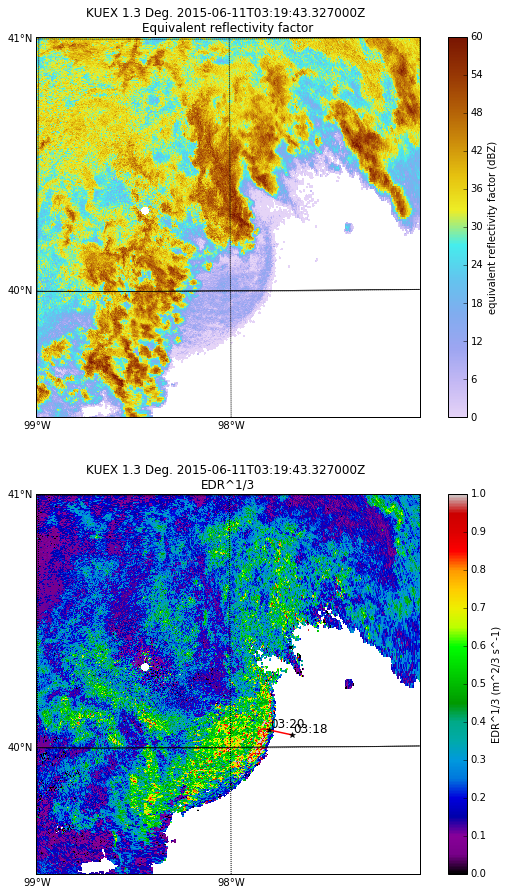

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10.0, 15.))
displayKUEX = pyart.graph.RadarMapDisplay(rKUEX)
#ax = fig.add_subplot(nrows, 2, index+1)
displayKUEX.plot_ppi_map('REF', radsweep, vmin=0., vmax=60.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='l',
            lat_0=rlat, lon_0=rlon, colorbar_flag=False, ax=ax1)
displayKUEX.plot_colorbar(ax=ax1)
f2 = FlightLevel(fltKA, basemap=displayKUEX.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=uwka_set[0], end_time=uwka_set[1],)
f2.time_stamps(start_time=uwka_set[0], end_time=uwka_set[1],
                           labelspacing=120)


displayKUEX.plot_ppi_map('turbulence', radsweep, vmin=0., vmax=1.,
            min_lon=lonl[0], max_lon=lonl[1], min_lat=latl[0], max_lat=latl[1],
            cmap='nipy_spectral',projection='aeqd', resolution='l',
            lat_0=rlat, lon_0=rlon, colorbar_flag=False, ax=ax2)
displayKUEX.plot_colorbar(ax=ax2)

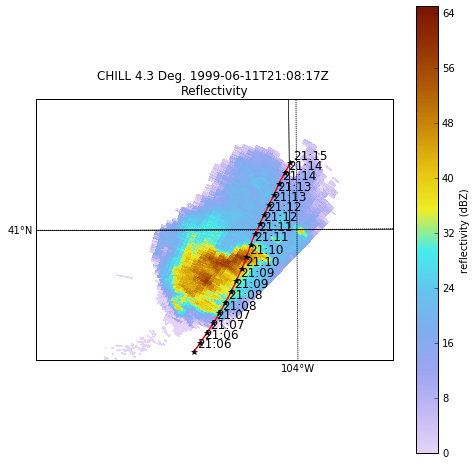

In [10]:
fig, (ax1) = plt.subplots(1, 1, figsize=(8.0, 8.))
displayCHILL = pyart.graph.RadarMapDisplay(rCHILL)
#ax = fig.add_subplot(nrows, 2, index+1)
displayCHILL.plot_ppi_map('DZ', chsweep, vmin=0., vmax=65.,
            min_lon=lonlt28[0], max_lon=lonlt28[1], min_lat=latlt28[0], max_lat=latlt28[1],
            cmap='pyart_LangRainbow12',projection='aeqd', resolution='l',
            lat_0=chlat, lon_0=chlon, colorbar_flag=False, ax=ax1)
displayCHILL.plot_colorbar(ax=ax1)
f2 = FlightLevel(flt28, basemap=displayCHILL.basemap)
f2.plot_trackmap(min_altitude=50., lw=2.5, track_color='red',
                start_time=t28_set[0], end_time=t28_set[1],)
f2.time_stamps(start_time=t28_set[0], end_time=t28_set[1],
                           labelspacing=600)

<b>Create an AWOT matching class with the radar data. Note that an individual or list of radar objects can be used.</b>

In [11]:
rmatchKUEX = awot.util.RadarMatch(fltKA, rKUEX,
                                  start_time=uwka_set[0], end_time=uwka_set[1])
rmatchCHILL = awot.util.RadarMatch(flt28, rflist, volume_update_time=70,
                                   mask_above=1E3,
                                   start_time=t28_set[0], end_time=t28_set[1])

<b>Use the KD-Tree method to find nearest neighbors</b>

In [12]:
kdKUEX = rmatchKUEX.kdtree(print_match_pairs=False)

--- 3.41447114944 seconds---


In [13]:
kdCHILL = rmatchCHILL.kdtree(print_match_pairs=False, leafsize=70)

--- 1.34842205048 seconds---


<b>Use a more classic nearest neighbor approach</b>

In [14]:
nnpKUEX = rmatchKUEX.near_neighbor()

/Users/guy/anaconda/lib/python2.7/site-packages/numpy/ma/core.py:4089: UserWarning: Warning: converting a masked element to nan.
  warnings.warn("Warning: converting a masked element to nan.")


--- 8.84114384651 seconds---


In [15]:
nnpCHILL = rmatchCHILL.near_neighbor()

--- 75.3486261368 seconds---


<b>Use a nearest neighbor tunneling approach</b>

In [16]:
nntKUEX = rmatchKUEX.near_neighbor_tunnel()

--- 0.362023830414 seconds---


In [17]:
nntCHILL = rmatchCHILL.near_neighbor_tunnel()

--- 7.68979382515 seconds---


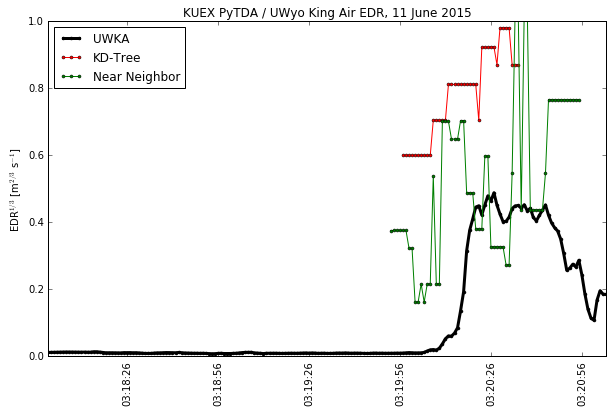

In [24]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(kdKUEX.flight['time']['data'], kdKUEX.flight['turb']['data'], '-ok', ms=3, lw=3, label='UWKA')
plt.plot(kdKUEX.flight['time']['data'], kdKUEX.data['turbulence']['data'], '-or', ms=3, label='KD-Tree')
#plt.plot(nntKUEX.flight['time']['data'], nntKUEX.data['turbulence']['data'], '-ob', ms=3, label='Near Neighbor Tunnel')
plt.plot(kdKUEX.flight['time']['data'], nnpKUEX.data['turbulence']['data'], '-og', ms=3, label='Near Neighbor')
ax.set_ylim(0, 1)
ax.set_ylabel(r'EDR$^{1/3}$ [m$^{2/3}$ s$^{-1}$]')
ax.set_title("KUEX PyTDA / UWyo King Air EDR, 11 June 2015")
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=3, loc='upper left')

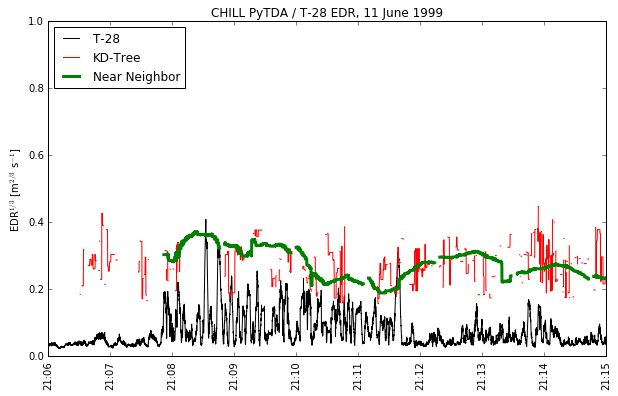

In [19]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(kdCHILL.flight['time']['data'], kdCHILL.flight['turb']['data']/100**(2/3), 'k', ms=2, label='T-28')
plt.plot(kdCHILL.flight['time']['data'], kdCHILL.data['turbulence']['data'], 'r', ms=2, label='KD-Tree')
#plt.plot(nntCHILL.flight['time']['data'], nntCHILL.data['turbulence']['data'], '.b', ms=3, label='Near Neighbor Tunnel')
plt.plot(kdCHILL.flight['time']['data'], nnpCHILL.data['turbulence']['data'], 'g', ms=3, lw=3, label='Near Neighbor')
#plt.plot(kdCHILL.flight['time']['data'], kdCHILL.data['turb_no_ntda']['data'], 'm')
ax.set_ylabel(r'EDR$^{1/3}$ [m$^{2/3}$ s$^{-1}$]')
ax.set_ylim(0, 1)
ax.set_title("CHILL PyTDA / T-28 EDR, 11 June 1999")
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=3, loc='upper left')

In [43]:
#np.ma.min(nnpCHILL['turbulence']['data']), nnpCHILL['turbulence']['data'].max(), 
#kdCHILL.data['turbulence']['data'].min()
#plt.hist(kdKUEX.data['turbulence']['data'][~np.isnan(kdKUEX.data['turbulence']['data'])])
#plt.hist(kdCHILL.data['turbulence']['data'][~np.isnan(kdCHILL.data['turbulence']['data'])])
#plt.hist(np.ma.masked_outside(np.ma.masked_invalid(kdCHILL.data['turbulence']['data']),0.,1.))
nntCHILL.data['turbulence']['data']

masked_array(data = [-- -- -- ..., -- -- --],
             mask = [ True  True  True ...,  True  True  True],
       fill_value = 1e+20)

In [19]:
#np.ravel(matchCHILL.data_numtime).shape, np.ravel(matchCHILL.data_height).shape, rCHILLj.elevation['data'].shape
rCHILLj.azimuth['data'].shape, rCHILLj.range['data'].shape,rCHILLj.altitude['data'].shape,rCHILLj.time['data'].shape,rCHILLj.fields['turbulence']['data'].shape

((6613,), (800,), (1,), (6613,), (6613, 800))

In [15]:
#kdCHILL.flight['time']['data'].shape, kdCHILL.data['turbulence']['data'].max()
rflist[0].gate_altitude['data'][0,:]
#help(rflist[0])
kdKUEX.indices_1d[0]

array([12, 12, 12, 12, 12, 12, 12, 12, 12, 12,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 10, 10, 10, 10, 10,  9,  8,  8,  8,  7,  7,  6,  5,  5,
        5,  5,  6,  6,  6])

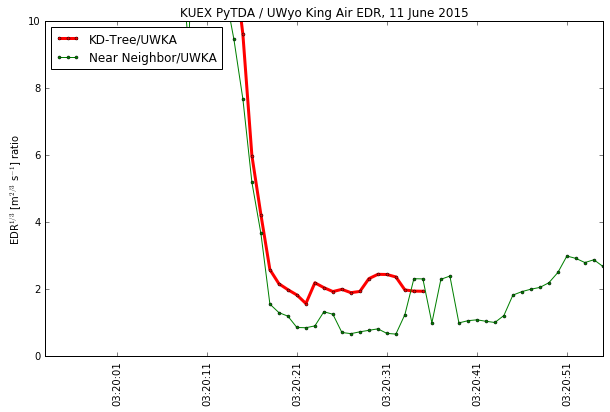

In [23]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(kdKUEX.flight['time']['data'], kdKUEX.data['turbulence']['data']/kdKUEX.flight['turb']['data'], '-or', ms=3, lw=3, label='KD-Tree/UWKA')
#plt.plot(nntKUEX.flight['time']['data'], nntKUEX.data['turbulence']['data'], '-ob', ms=3, label='Near Neighbor Tunnel')
plt.plot(kdKUEX.flight['time']['data'], nnpKUEX.data['turbulence']['data']/kdKUEX.flight['turb']['data'], '-og', ms=3, label='Near Neighbor/UWKA')
ax.set_ylim(0, 10)
ax.set_ylabel(r'EDR$^{1/3}$ [m$^{2/3}$ s$^{-1}$] ratio')
ax.set_title("KUEX PyTDA / UWyo King Air EDR, 11 June 2015")
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=3, loc='upper left')

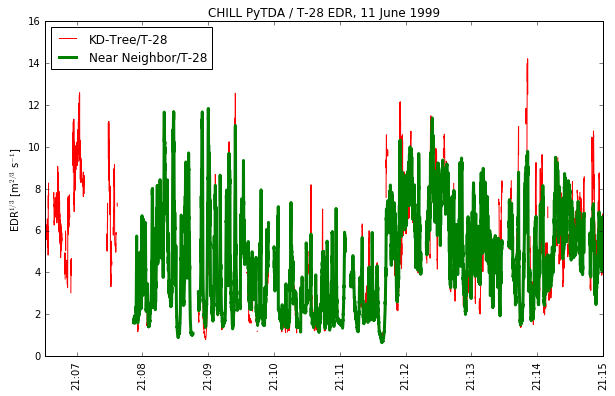

In [27]:
fig,ax = plt.subplots(1,1, figsize=(10,6))
plt.plot(kdCHILL.flight['time']['data'], kdCHILL.data['turbulence']['data']/(kdCHILL.flight['turb']['data']/100**(2/3)), 'r', ms=2, label='KD-Tree/T-28')
plt.plot(kdCHILL.flight['time']['data'], nnpCHILL.data['turbulence']['data']/(kdCHILL.flight['turb']['data']/100**(2/3)), 'g', ms=3, lw=3, label='Near Neighbor/T-28')
ax.set_ylabel(r'EDR$^{1/3}$ [m$^{2/3}$ s$^{-1}$]')
#ax.set_ylim(0, 1)
ax.set_title("CHILL PyTDA / T-28 EDR, 11 June 1999")
xfmt = md.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(xfmt)
plt.xticks(rotation=90)
plt.legend(numpoints=3, loc='upper left')